In [312]:
import sys
import numpy as np
import random
import pickle
import os
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import json
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

import models

sys.path.append("../../../FedLab/")

from fedlab.utils.dataset import functional as dataF
from fedlab.utils import SerializationTool
from fedlab.utils.functional import save_dict, load_dict

In [46]:
from fedlab.utils.dataset import CIFAR100Partitioner

In [275]:
model = getattr(models, 'Cifar10Net')('Cifar10Net')

In [276]:
params1 = SerializationTool.serialize_model(model)
params2 = SerializationTool.serialize_model(model)
params3 = params1.data
params4 = params1

print(params1)
print(params2)
print(params3)


tensor([-0.0998,  0.0264,  0.0098,  ...,  0.0510,  0.0562,  0.0555])
tensor([-0.0998,  0.0264,  0.0098,  ...,  0.0510,  0.0562,  0.0555])
tensor([-0.0998,  0.0264,  0.0098,  ...,  0.0510,  0.0562,  0.0555])


In [278]:
params1.dtype

torch.float32

In [98]:
params1 is params2, params1 is params3, params1 is params4, params1.data is params3

(False, False, True, False)

In [97]:
print(type(params1), params1.requires_grad)
print(type(params2), params2.requires_grad)
print(type(params3), params3.requires_grad)
print(type(params4), params4.requires_grad)

<class 'torch.Tensor'> False
<class 'torch.Tensor'> False
<class 'torch.Tensor'> False
<class 'torch.Tensor'> False


In [182]:
def str2list(str):
    lis = str[1:-1].split(',')
    res = []
    for i, ele in enumerate(lis):
        if len(lis[i]) > 0:
            res.append(float(ele))
    
    return res

def result_file_parser(file_name):
    res = dict()
    with open(file_name) as f:
        for line in f.readlines():
            line = line.strip()
            if line[0]=='{':
                line = line.replace("\'", "\"")
                res['setting'] = json.loads(line)
            else:
                line = line.split(':')
                key_name, value_str = line[0], line[1]
                values = str2list(value_str)
                if len(values)>0:
                    res[key_name] = values
    return res

In [337]:
# res_files = [file for file in os.listdir("./Output/") if file[:7] in ['FedDyn_', 'FedAvg_']]
# all_res = dict()
# for fn in res_files:
#     all_res[fn] = result_file_parser(os.path.join('./Output/', fn))

# feddyn_file = [file for file in res_files if file[:7]=='FedDyn_' and file[:7]][0]
# fedavg_file = [file for file in res_files if file[:7]=='FedAvg_'][0]

# feddyn_res = all_res[feddyn_file]
# fedavg_res = all_res[fedavg_file]
fedlab_fedavg_standalone = result_file_parser(os.path.join('./Output/', 'FedAvg_Cifar10Net_iid_cifar10-standalone.txt'))
fedlab_fedavg_scale = result_file_parser(os.path.join('./Output/', 'FedAvg_Cifar10Net_iid_cifar10_scale.txt'))
fedlab_feddyn_single_save = result_file_parser(os.path.join('./Output/', 'FedDyn_Cifar10Net_iid_cifar10_single_save.txt'))

In [348]:
feddyn_feddyn_res1 = torch.load('./Output/feddyn-FedDyn_metrics_run1.pkl')
feddyn_feddyn_res2 = torch.load('./Output/feddyn-FedDyn_metrics_run2.pkl')
feddyn_fedavg_res1 = torch.load('./Output/feddyn-FedAvg_metrics_run1.pkl')
feddyn_fedavg_res2 = torch.load('./Output/feddyn-FedAvg_metrics_run2.pkl')

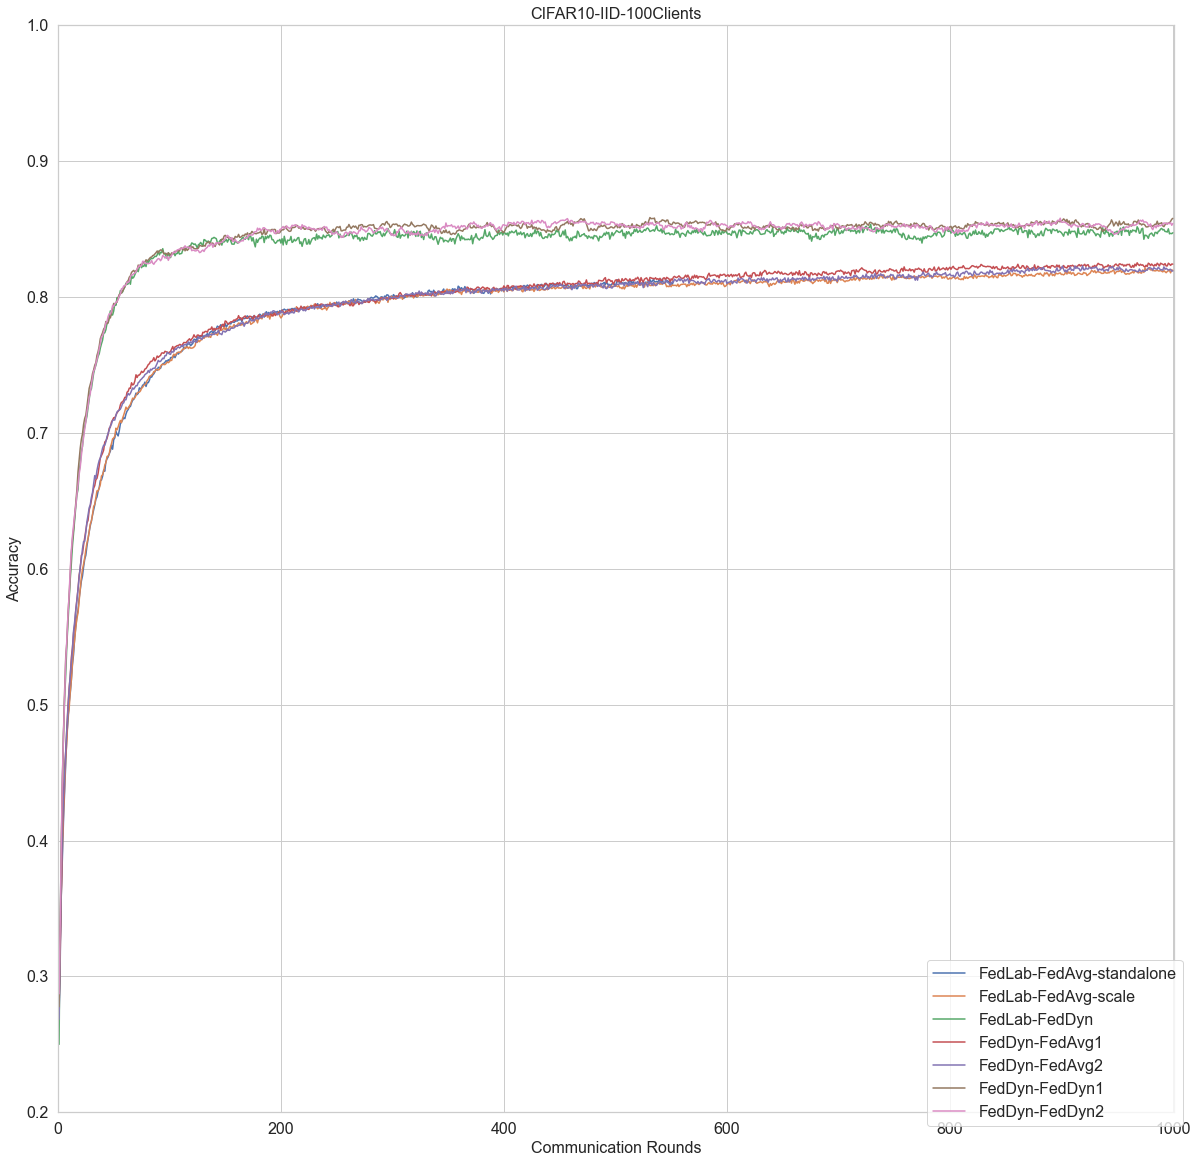

In [349]:
plt.figure(figsize=(20, 20))
plt.plot(np.arange(len(fedlab_fedavg_standalone['acc']))+1, fedlab_fedavg_standalone['acc'], label='FedLab-FedAvg-standalone')
plt.plot(np.arange(len(fedlab_fedavg_scale['acc']))+1, fedlab_fedavg_scale['acc'], label='FedLab-FedAvg-scale')
plt.plot(np.arange(len(fedlab_feddyn_single_save['cld_mdl_test_acc']))+1, fedlab_feddyn_single_save['cld_mdl_test_acc'], label='FedLab-FedDyn')

plt.plot(np.arange(1000)+1, feddyn_fedavg_res1['tst_perf_sel_FedAvg'][:,1], label='FedDyn-FedAvg1')
plt.plot(np.arange(1000)+1, feddyn_fedavg_res2['tst_perf_sel_FedAvg'][:,1], label='FedDyn-FedAvg2')

plt.plot(np.arange(1000)+1, feddyn_feddyn_res1['tst_perf_sel_FedDyn'][:,1], label='FedDyn-FedDyn1')
plt.plot(np.arange(1000)+1, feddyn_feddyn_res2['tst_perf_sel_FedDyn'][:,1], label='FedDyn-FedDyn2')

plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.015, -0.02))
plt.xlim([0, len(fedavg_res['acc'])+1])
plt.ylim([0.2, 1.0])
plt.title('CIFAR10-IID-100Clients', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.2, 1.05, step=0.1),fontsize=16)
plt.grid(True)
plt.savefig('./Output/CIFAR10_100_iid_plots.png', dpi=1000, bbox_inches='tight')
# plt.show() 

In [344]:
acc1 = 0.814
acc2 = 0.85
paper_acc1_round = 67
paper_acc2_round = 198
feddyn_feddyn1_acc1_round = np.argwhere(feddyn_feddyn_res1['tst_perf_sel_FedDyn'][:,1]>=acc1)[0,0] + 1
feddyn_feddyn1_acc2_round = np.argwhere(feddyn_feddyn_res1['tst_perf_sel_FedDyn'][:,1]>=acc2)[0,0] + 1
feddyn_feddyn2_acc1_round = np.argwhere(feddyn_feddyn_res2['tst_perf_sel_FedDyn'][:,1]>=acc1)[0,0] + 1
feddyn_feddyn2_acc2_round = np.argwhere(feddyn_feddyn_res2['tst_perf_sel_FedDyn'][:,1]>=acc2)[0,0] + 1
fedlab_feddyn_acc1_round = np.argwhere(np.array(feddyn_res['cld_mdl_test_acc'])>=acc1)[0,0] + 1
fedlab_feddyn_acc2_round = np.argwhere(np.array(feddyn_res['cld_mdl_test_acc'])>=acc2)[0,0] + 1

# fedlab_fedavg_scale_acc1_round = np.argwhere(np.array(fedlab_fedavg_scale['acc'])>=acc1)[0,0] + 1
# fedlab_fedavg_scale_acc2_round = np.argwhere(np.array(fedlab_fedavg_scale['acc'])>=acc2)[0,0] + 1
# fedlab_fedavg_standalone_acc1_round = np.argwhere(np.array(fedlab_fedavg_standalone['acc'])>=acc1)[0,0] + 1
# fedlab_fedavg_standalone_acc2_round = np.argwhere(np.array(fedlab_fedavg_standalone['acc'])>=acc2)[0,0] + 1


print("                         Paper   FedDyn1   FedDyn2   FedLab-feddyn   FedLab-FedAvg-standalone    FedLab-FedAvg-scale")
print(f"Round for acc>{acc1*100:.2f}%: {paper_acc1_round:8d},"
                                     f"{feddyn_feddyn1_acc1_round:8d},"
                                     f"{feddyn_feddyn2_acc1_round:8d},"
                                     f"{fedlab_feddyn_acc1_round:15d},")
#                                      f"{fedlab_fedavg_standalone_acc1_round:13d},"
#                                      f"{fedlab_fedavg_scale_acc1_round:13d},")  
print(f"Round for acc>{acc2*100:.2f}%: {paper_acc2_round:8d},"
                                     f"{feddyn_feddyn1_acc2_round:8d},"
                                     f"{feddyn_feddyn2_acc2_round:8d},"
                                     f"{fedlab_feddyn_acc2_round:15d},")
#                                      f"{fedlab_fedavg_standalone_acc2_round:13d},"
#                                      f"{fedlab_fedavg_scale_acc2_round:13d},")

                         Paper   FedDyn1   FedDyn2   FedLab-feddyn   FedLab-FedAvg-standalone    FedLab-FedAvg-scale
Round for acc>81.40%:       67,      64,      65,             66,
Round for acc>85.00%:      198,     185,     179,            296,


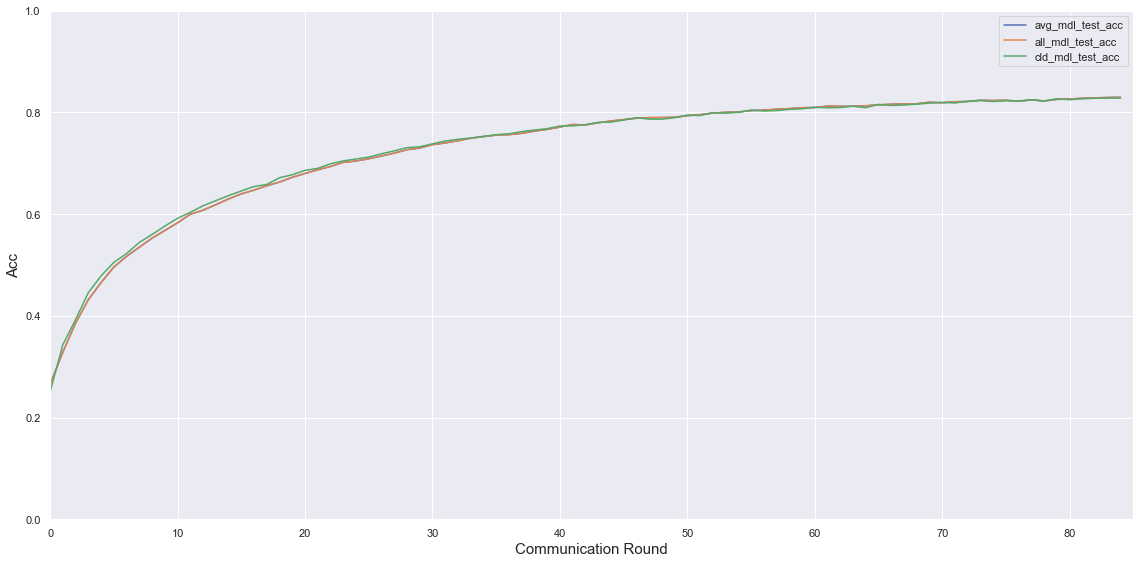

In [190]:
# all_res = dict()
# for fn in res_files:
#     all_res[fn] = result_file_parser(os.path.join('./Output/', fn))

# round_num = len(all_res[res_files[0]]['all_mdl_test_acc'])
# round_col = list(range(round_num))
# content = {key:all_res[res_files[0]][key] for key in all_res[res_files[0]] if key!='setting'}
# content['Round'] = round_col

# res_df = pd.DataFrame(content)
# res_df['Round'] = res_df['Round'].astype(int)
# # res_df = res_df.set_index('Round')
# col_names = list(res_df.columns)

# colors = ["#FF0B04", "#4374B3"]# Set your custom color palette
# xy_fz = 15
# title_fz = 20

# sns.set_palette(sns.color_palette(colors))
# sns.set_theme(style="ticks")
# sns.set_style("darkgrid")
# fig = plt.figure(figsize=(16, 8))  # create a figure object
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
# # plt.figure(figsize=(16, 8))
# plt.ylim([0, 1])
# plt.xlim([0,round_num])

# res_df.plot(x='Round', y=[key for key in col_names if key[-3:]=='acc'], grid=True, ax=ax)
# plt.xlabel('Communication Round',fontsize=xy_fz)
# plt.ylabel('Acc',fontsize=xy_fz)
# # plt.xticks(list(range(round_num)))
# plt.tight_layout()
# plt.savefig("./Output/feddyn-cifar10-acc.png",dpi=700)

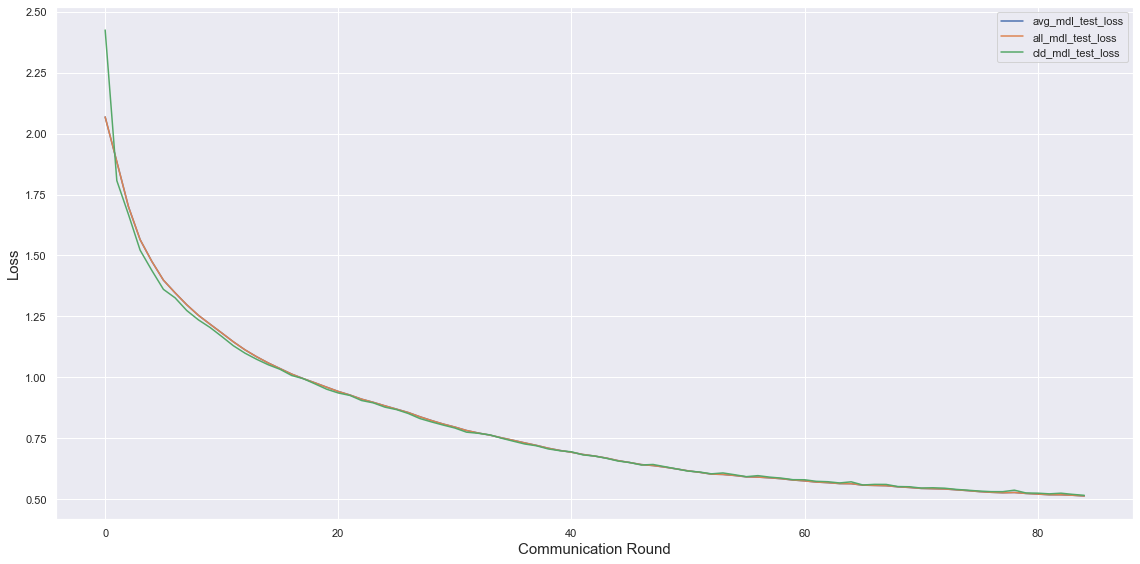

In [191]:
# colors = ["#FF0B04", "#4374B3"]# Set your custom color palette
# xy_fz = 15
# title_fz = 20

# sns.set_palette(sns.color_palette(colors))
# sns.set_theme(style="ticks")
# sns.set_style("darkgrid")
# fig = plt.figure(figsize=(16, 8))  # create a figure object
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
# # plt.figure(figsize=(16, 8))
# # plt.ylim([0, 1])

# res_df.plot(x='Round', y=[key for key in col_names if key[-4:]=='loss'], grid=True, ax=ax)
# plt.xlabel('Communication Round',fontsize=xy_fz)
# plt.ylabel('Loss',fontsize=xy_fz)
# # plt.xticks(list(range(round_num)))
# plt.tight_layout()
# # plt.savefig("./imgs/cifar10-feddyn-acc.png",dpi=400)

In [166]:
from datetime import datetime

In [171]:
date_time_str_start = '2021-10-23 23:54:49'
date_time_str_end = '2021-10-24 2:35:43'

date_time_start = datetime.strptime(date_time_str_start, '%Y-%m-%d %H:%M:%S')
date_time_end = datetime.strptime(date_time_str_end, '%Y-%m-%d %H:%M:%S')

print((date_time_end - date_time_start).total_seconds() / 60.0)

print ("The type of the date is now",  type(date_time_start))
print ("The date is", date_time_start)

160.9
The type of the date is now <class 'datetime.datetime'>
The date is 2021-10-23 23:54:49


In [292]:
479.87/60

7.997833333333333

In [293]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

In [297]:
trainset = torchvision.datasets.CIFAR10(root='../../../data/CIFAR10/',
                                            train=True,
                                            download=False,
                                            transform=transform_train)
data_indices = load_dict('Output/cifar10_iid.pkl')

In [299]:
data_indices[0]

array([11841, 19602, 45519, ..., 21733, 48297, 37441])

In [306]:
trainset.data[data_indices[0]].shape, len(np.array(trainset.targets)[data_indices[0]].tolist())

((1666, 32, 32, 3), 1666)

In [317]:
tmp = Image.fromarray(trainset.data[0])
tmp.

In [332]:
class Subset(torch.utils.data.Dataset):
    """For data subset with different augmentation.
    """
    def __init__(self, dataset, indices, transform=None, target_transform=None):
        self.data = []
        for idx in indices:
            self.data.append(Image.fromarray(dataset.data[idx]))
        if not isinstance(dataset.targets, np.ndarray):
            dataset.targets = np.array(dataset.targets)
        self.targets = dataset.targets[indices].tolist()
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img, label = self.data[index], self.targets[index]
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label

    def __len__(self):
        return len(self.targets)


In [346]:
1580/60

26.333333333333332